In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import joblib



In [ ]:
# Load dataset
df = pd.read_csv("inventory_data.csv")

df.head()

,Date,Item_ID,Item_Type,Item_Name,Current_Stock,Min_Required,Max_Capacity,Unit_Cost,Avg_Usage_Per_Day,Restock_Lead_Time,Vendor_ID
0,2024-10-01,105,Consumable,Ventilator,1542,264,1018,4467.55,108,17,V001
1,2024-10-02,100,Equipment,Ventilator,2487,656,3556,5832.29,55,12,V001
2,2024-10-03,103,Equipment,Surgical Mask,2371,384,5562,16062.98,470,6,V001
3,2024-10-04,103,Consumable,Surgical Mask,2038,438,1131,744.10,207,15,V002
4,2024-10-05,107,Equipment,IV Drip,2410,338,1013,15426.53,158,12,V003


In [3]:
df.drop(columns=['Item_ID' , 'Item_Type' , 'Item_Name' , 'Current_Stock' , 'Min_Required' , 'Max_Capacity' , 'Unit_Cost' , 'Restock_Lead_Time' , 'Vendor_ID'], inplace=True)

df.head()

,Date,Avg_Usage_Per_Day
0,2024-10-01,108
1,2024-10-02,55
2,2024-10-03,470
3,2024-10-04,207
4,2024-10-05,158


In [4]:
df["Date"] = pd.to_datetime(df["Date"])

df.to_csv('avg_daily_usage.csv')

In [5]:
df['Year'] = df['Date'].dt.year  # Extracts the year
df['Month'] = df['Date'].dt.month  # Extracts the month (1-12)
df['Day'] = df['Date'].dt.day  # Extracts the day of the month
df['Weekday'] = df['Date'].dt.day_name()  # Extracts the name of the weekday
df["Quarter"] = df["Date"].dt.quarter   # Extracts the quarter

df.head()

,Date,Avg_Usage_Per_Day,Year,Month,Day,Weekday,Quarter
0,2024-10-01,108,2024,10,1,Tuesday,4
1,2024-10-02,55,2024,10,2,Wednesday,4
2,2024-10-03,470,2024,10,3,Thursday,4
3,2024-10-04,207,2024,10,4,Friday,4
4,2024-10-05,158,2024,10,5,Saturday,4


In [6]:
# ordinal data encoding for weekday

ordinal_mapping = {'Saturday': 1, 'Sunday': 2, 'Monday': 3, 'Tuesday': 4, 'Wednesday': 5, 'Thursday': 6, 'Friday': 7}  
df['Weekday'].replace(ordinal_mapping, inplace=True)

df.head()

C:\Users\salma\AppData\Local\Temp\ipykernel_21940\4061150951.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Weekday'].replace(ordinal_mapping, inplace=True)
C:\Users\salma\AppData\Local\Temp\ipykernel_21940\4061150951.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Weekday'].replace

,Date,Avg_Usage_Per_Day,Year,Month,Day,Weekday,Quarter
0,2024-10-01,108,2024,10,1,4,4
1,2024-10-02,55,2024,10,2,5,4
2,2024-10-03,470,2024,10,3,6,4
3,2024-10-04,207,2024,10,4,7,4
4,2024-10-05,158,2024,10,5,1,4


In [7]:
# cyclical encoding for time features

# month

df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# day

df['day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

# weekday

df['weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)

# quarter

df['quarter_sin'] = np.sin(2 * np.pi * df['Quarter'] / 4)
df['quarter_cos'] = np.cos(2 * np.pi * df['Quarter'] / 4)

df.head()

,Date,Avg_Usage_Per_Day,Year,Month,Day,Weekday,Quarter,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,quarter_sin,quarter_cos
0,2024-10-01,108,2024,10,1,4,4,-0.866025,0.5,0.201299,0.979530,-4.338837e-01,-0.900969,-2.449294e-16,1.0
1,2024-10-02,55,2024,10,2,5,4,-0.866025,0.5,0.394356,0.918958,-9.749279e-01,-0.222521,-2.449294e-16,1.0
2,2024-10-03,470,2024,10,3,6,4,-0.866025,0.5,0.571268,0.820763,-7.818315e-01,0.623490,-2.449294e-16,1.0
3,2024-10-04,207,2024,10,4,7,4,-0.866025,0.5,0.724793,0.688967,-2.449294e-16,1.000000,-2.449294e-16,1.0
4,2024-10-05,158,2024,10,5,1,4,-0.866025,0.5,0.848644,0.528964,7.818315e-01,0.623490,-2.449294e-16,1.0


In [8]:
# drop unnecessary columns

df.drop(columns=['Date' , 'Month' , 'Day' , 'Weekday' , 'Quarter'], inplace=True)

df.head()

,Avg_Usage_Per_Day,Year,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,quarter_sin,quarter_cos
0,108,2024,-0.866025,0.5,0.201299,0.979530,-4.338837e-01,-0.900969,-2.449294e-16,1.0
1,55,2024,-0.866025,0.5,0.394356,0.918958,-9.749279e-01,-0.222521,-2.449294e-16,1.0
2,470,2024,-0.866025,0.5,0.571268,0.820763,-7.818315e-01,0.623490,-2.449294e-16,1.0
3,207,2024,-0.866025,0.5,0.724793,0.688967,-2.449294e-16,1.000000,-2.449294e-16,1.0
4,158,2024,-0.866025,0.5,0.848644,0.528964,7.818315e-01,0.623490,-2.449294e-16,1.0


In [9]:
df['lag_1'] = df['Avg_Usage_Per_Day'].shift(1)
df['lag_2'] = df['Avg_Usage_Per_Day'].shift(2)

df['rolling_mean_3'] = df['Avg_Usage_Per_Day'].rolling(3).mean()

df.head()

,Avg_Usage_Per_Day,Year,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,quarter_sin,quarter_cos,lag_1,lag_2,rolling_mean_3
0,108,2024,-0.866025,0.5,0.201299,0.979530,-4.338837e-01,-0.900969,-2.449294e-16,1.0,NaN,NaN,NaN
1,55,2024,-0.866025,0.5,0.394356,0.918958,-9.749279e-01,-0.222521,-2.449294e-16,1.0,108.0,NaN,NaN
2,470,2024,-0.866025,0.5,0.571268,0.820763,-7.818315e-01,0.623490,-2.449294e-16,1.0,55.0,108.0,211.000000
3,207,2024,-0.866025,0.5,0.724793,0.688967,-2.449294e-16,1.000000,-2.449294e-16,1.0,470.0,55.0,244.000000
4,158,2024,-0.866025,0.5,0.848644,0.528964,7.818315e-01,0.623490,-2.449294e-16,1.0,207.0,470.0,278.333333


In [10]:
df.dropna(inplace=True)


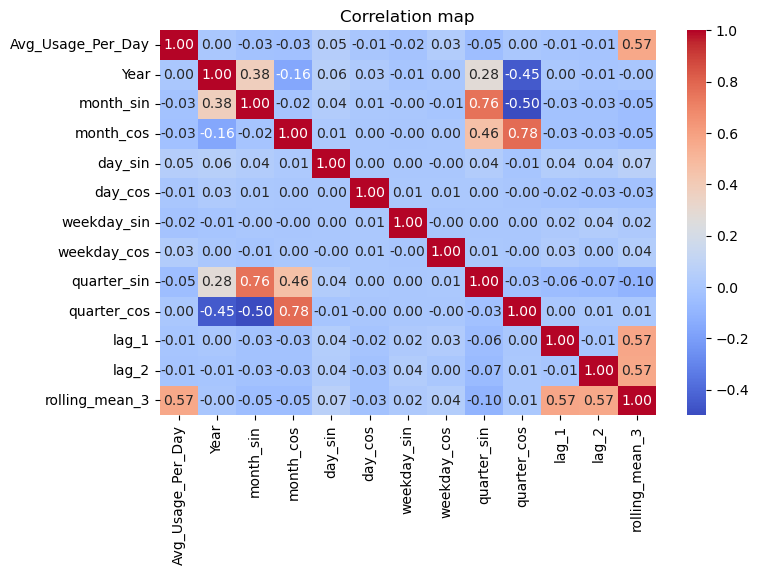

In [11]:
# Correlation map

import seaborn as sns  # For advanced visualizations

plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation map")
plt.show()

In [12]:
# Define features and target

X = df.drop(['Avg_Usage_Per_Day'], axis=1)
y = df['Avg_Usage_Per_Day']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [13]:
# Model 1: Random Forest


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

# Print metrics
print(f"MAE: {mae}, RMSE: {rmse}, R-squared: {r2}")

MAE: 41.7384, RMSE: 49.87707363107824, R-squared: 0.8582032778578026


In [14]:
# Model 2: XGBoost

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

# Print metrics
print(f"MAE: {mae}, RMSE: {rmse}, R-squared: {r2}")


MAE: 37.1843631362915, RMSE: 46.47064914832434, R-squared: 0.8769103288650513


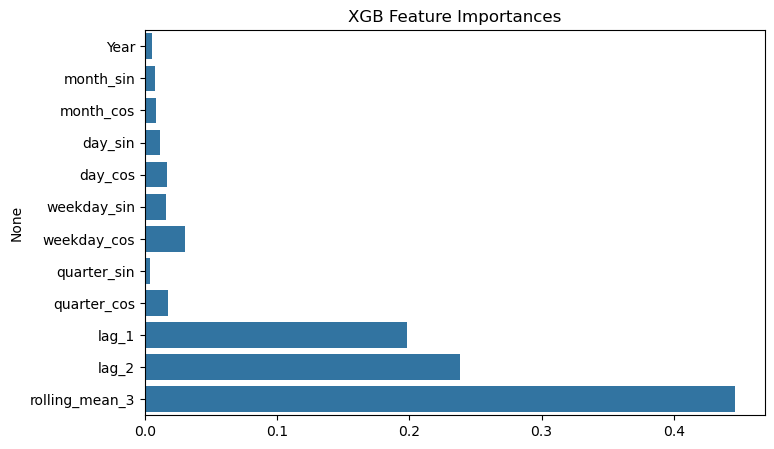

In [15]:
importances = xgb_model.feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("XGB Feature Importances")
plt.show()

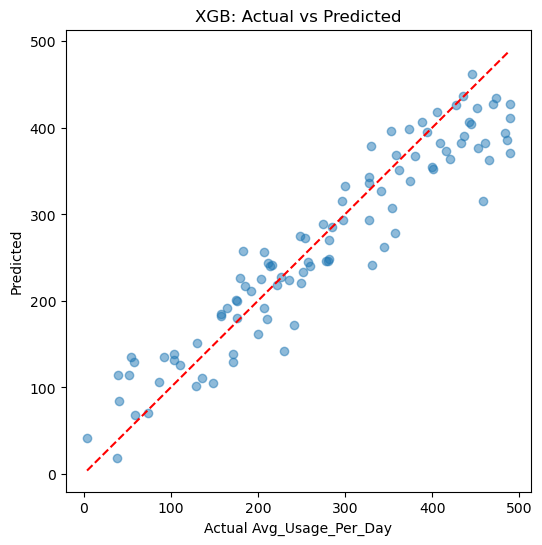

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Avg_Usage_Per_Day")
plt.ylabel("Predicted")
plt.title("XGB: Actual vs Predicted")
plt.show()

In [17]:
X = df.drop(columns = ['Avg_Usage_Per_Day' , 'Year' , 'quarter_sin'], axis=1)
y = df['Avg_Usage_Per_Day']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Model 2: XGBoost

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

# Print metrics
print(f"MAE: {mae}, RMSE: {rmse}, R-squared: {r2}")


MAE: 37.08665555953979, RMSE: 46.06418960376961, R-squared: 0.8790541291236877


In [19]:


# Define your XGB model (no need to fit yet)
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit search
grid_search.fit(X_train, y_train)

# Best params
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [20]:
# Predict with best model
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

MAE: 23.38, RMSE: 29.41, R²: 0.9507


In [21]:
# modified grid search

# Define your XGB model (no need to fit yet)
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

# Define parameter grid
param_grid = {
    'n_estimators': [150, 200, 250, 300],         # Narrow around 200
    'max_depth': [2, 3, 4],                       # Slightly shallower/ deeper
    'learning_rate': [0.05, 0.1, 0.15],           # Finer around 0.1
    'subsample': [0.7, 0.8, 0.9],                 # Nearby values to 0.8
    'colsample_bytree': [0.9, 1.0]                # Nearby to 1.0
}

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit search
grid_search.fit(X_train, y_train)

# Best params
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.8}


In [22]:
# Predict with best model
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

MAE: 20.56, RMSE: 25.70, R²: 0.9623


In [23]:
# modified grid search 2

# Define your XGB model (no need to fit yet)
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

# Define parameter grid
param_grid = {
    'n_estimators': [280, 300, 320],
    'max_depth': [2, 3],
    'learning_rate': [0.12, 0.15, 0.18],
    'subsample': [0.75, 0.8, 0.85],
    'colsample_bytree': [0.85, 0.9, 0.95],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.05, 0.1],
    'reg_alpha': [0, 0.01, 0.1],     # L1 regularization
    'reg_lambda': [1, 1.2, 1.5]      # L2 regularization
}

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit search
grid_search.fit(X_train, y_train)

# Best params
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 13122 candidates, totalling 65610 fits
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.18, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 320, 'reg_alpha': 0.1, 'reg_lambda': 1.2, 'subsample': 0.8}


In [24]:
# Predict with best model
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

MAE: 19.11, RMSE: 24.08, R²: 0.9669


In [ ]:

# Save the fitted model
joblib.dump(best_xgb, 'AVG_xgb.pkl')



['AVG_xgb.pkl']